## Vehicle Detection Project
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier, 
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import time
from collections import deque
#%matplotlib qt

# load files from vehicles and non-vehicles
def LoadImages(root):
    images = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            fname = os.path.join(path, name)
            if fname.endswith('.png'):
                images.append(fname)
    return images

car_images = LoadImages('./vehicles')
notcar_images = LoadImages('./non-vehicles')

print(len(car_images))
print(len(notcar_images))
#car_images = glob.glob('./vehicles/GTI_Far/*.png')
#print(len(car_images))

C:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


8792
8968


# Feature Extraction

In [2]:
# defining parameters
class Parameters():
    def __init__(self):
        # color channel
        self.color_space = 'YCrCb'
        # HOG parameters
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # spatial parameter
        self.spatial_size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)
        self.spatial_feat=True
        self.hist_feat=True
        self.hog_feat=True

param = Parameters()

In [3]:
# defining functions for feature extractions
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, param):
    # color channel
    color_space = param.color_space
    spatial_size= param.spatial_size
    hist_bins= param.hist_bins
    orient = param.orient
    pix_per_cell = param.pix_per_cell
    cell_per_block = param.cell_per_block
    hog_channel = param.hog_channel
    
    spatial_feat = param.spatial_feat
    hist_feat = param.hist_feat
    hog_feat = param.hog_feat
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True: # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [4]:
t = time.time()
car_features = extract_features(car_images, param)
notcar_features = extract_features(notcar_images, param)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# scale the data
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=rand_state)

print('Using:', param.orient,' orientations',param.pix_per_cell,' pixels per cell and', param.cell_per_block,' cells per block')
print('Feature vector length: ', len(X_train[0]))

54.31 Seconds to extract features...
Using: 8  orientations 8  pixels per cell and 2  cells per block
Feature vector length:  5568


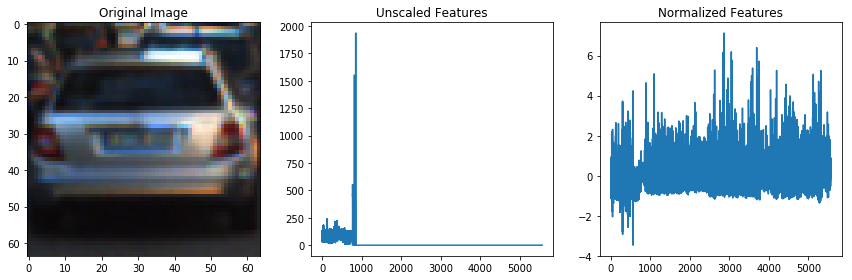

In [5]:
# plotting the histogram of normalized and unnormalized features
idx = np.random.randint(0, len(car_images))
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(cv2.imread(car_images[idx]), cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[idx])
plt.title('Unscaled Features')
plt.subplot(133)
plt.plot(X_scaled[idx])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

In [6]:
import time
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

8.49 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


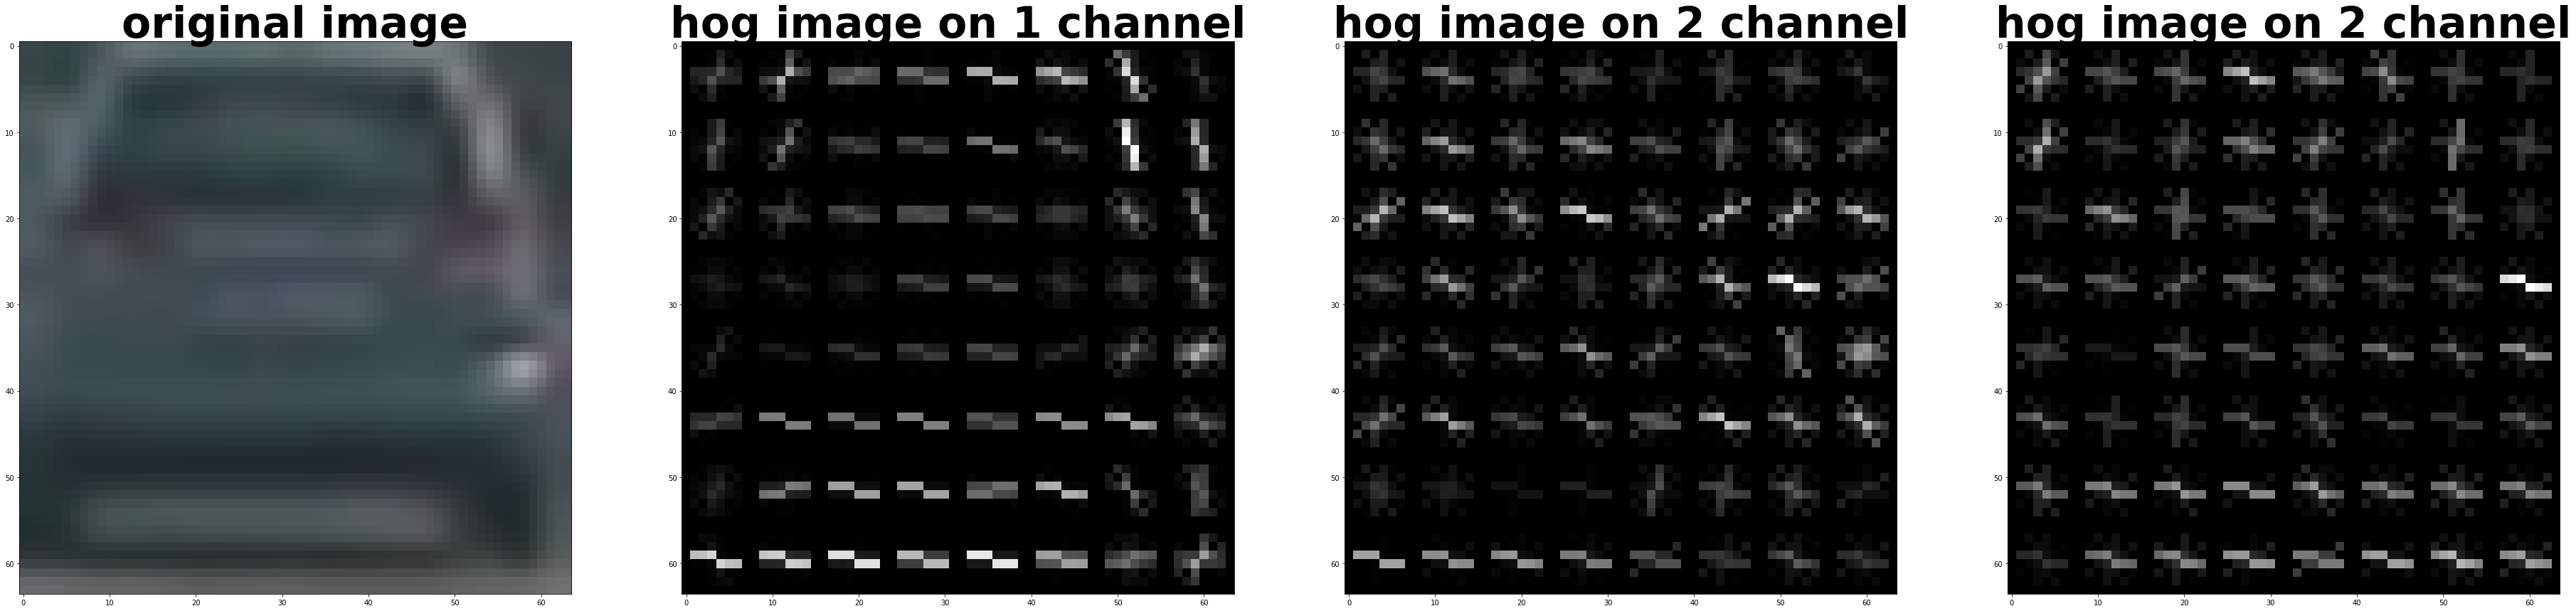

In [7]:
# image visualization using HOG features
idx= 10
image = cv2.cvtColor(cv2.imread(car_images[idx]), cv2.COLOR_BGR2RGB)
cvt_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
features1, hog_img1 = get_hog_features(cvt_image[:,:,0], param.orient, param.pix_per_cell, param.cell_per_block, vis=True, feature_vec=True)
features2, hog_img2 = get_hog_features(cvt_image[:,:,1], param.orient, param.pix_per_cell, param.cell_per_block, vis=True, feature_vec=True)
features3, hog_img3 = get_hog_features(cvt_image[:,:,2], param.orient, param.pix_per_cell, param.cell_per_block, vis=True, feature_vec=True)
f, axarr = plt.subplots(1, 4, figsize = (64, 64))

axarr[0].imshow(image)
axarr[0].set_title('original image',fontweight="bold", size=60)
axarr[1].imshow(hog_img1, cmap = 'gray')
axarr[1].set_title('hog image on 1 channel',fontweight="bold", size=60)
axarr[2].imshow(hog_img2, cmap = 'gray')
axarr[2].set_title('hog image on 2 channel',fontweight="bold", size=60)
axarr[3].imshow(hog_img3, cmap = 'gray')
axarr[3].set_title('hog image on 2 channel',fontweight="bold", size=60)

plt.show()

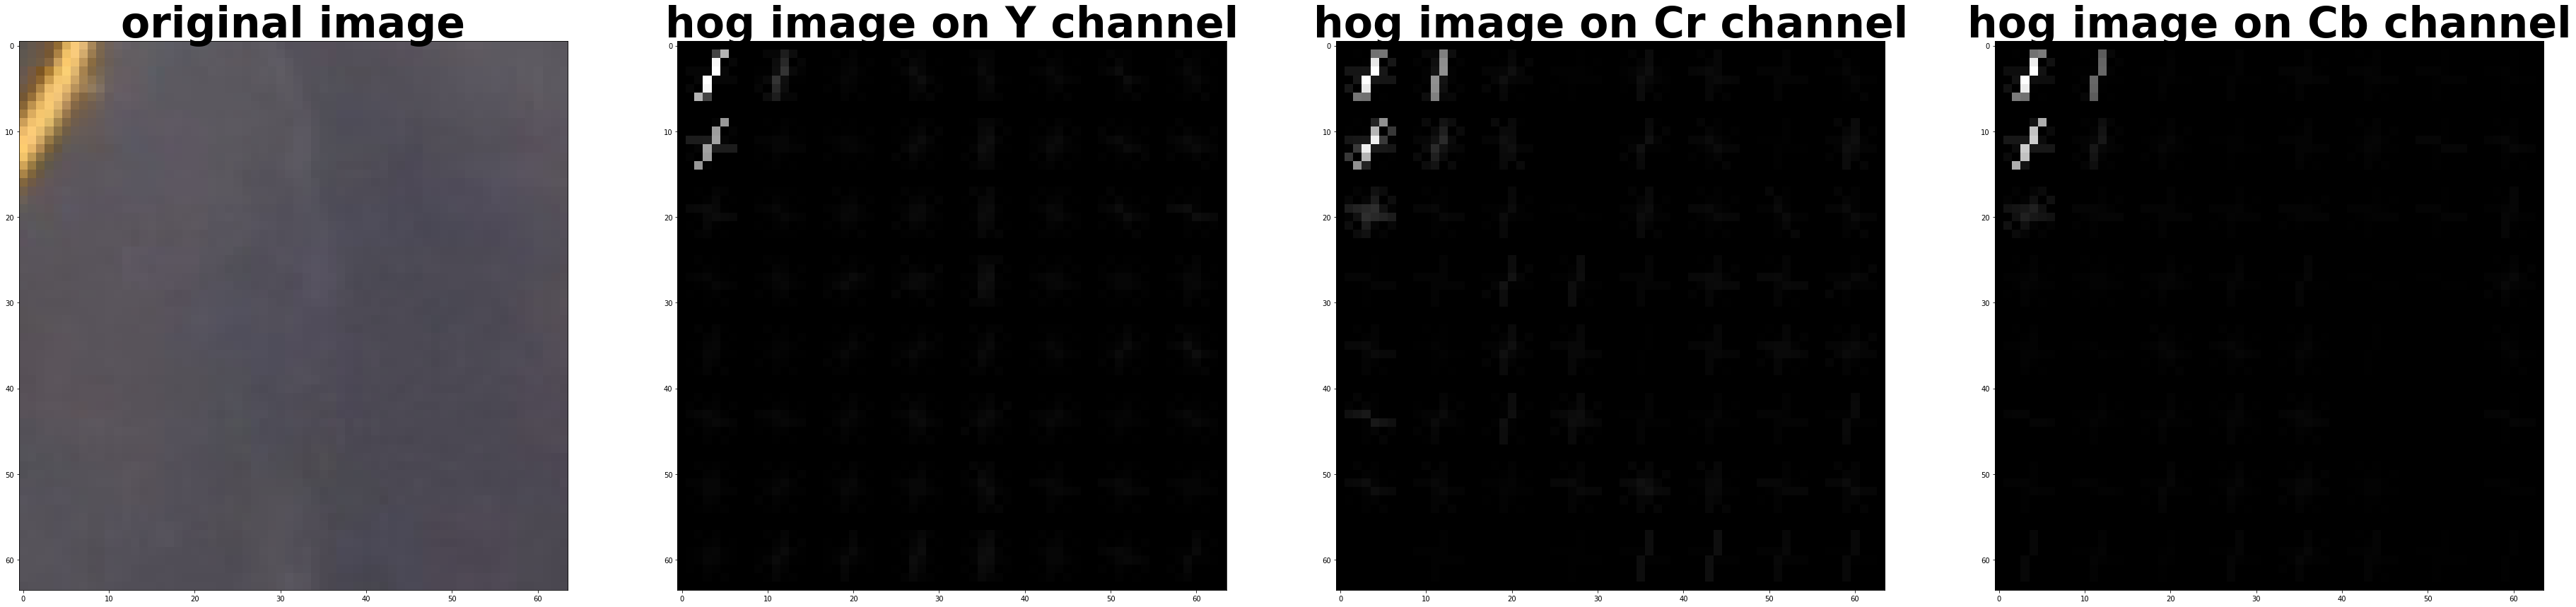

In [8]:
idx2 = 11
notcarimage = cv2.cvtColor(cv2.imread(notcar_images[idx2]), cv2.COLOR_BGR2RGB)
cvt_notcarimage = cv2.cvtColor(notcarimage, cv2.COLOR_RGB2YCrCb)
feaY, hog_imgY = get_hog_features(cvt_notcarimage[:,:,0], param.orient, param.pix_per_cell, param.cell_per_block, vis=True, feature_vec=True)
feaCr, hog_imgCr = get_hog_features(cvt_notcarimage[:,:,1], param.orient, param.pix_per_cell, param.cell_per_block, vis=True, feature_vec=True)
feaCb, hog_imgCb = get_hog_features(cvt_notcarimage[:,:,2], param.orient, param.pix_per_cell, param.cell_per_block, vis=True, feature_vec=True)
f, axarr = plt.subplots(1, 4, figsize = (64, 64))

axarr[0].imshow(notcarimage)
axarr[0].set_title('original image',fontweight="bold", size=60)
axarr[1].imshow(hog_imgY, cmap = 'gray')
axarr[1].set_title('hog image on Y channel',fontweight="bold", size=60)
axarr[2].imshow(hog_imgCr, cmap = 'gray')
axarr[2].set_title('hog image on Cr channel',fontweight="bold", size=60)
axarr[3].imshow(hog_imgCb, cmap = 'gray')
axarr[3].set_title('hog image on Cb channel',fontweight="bold", size=60)
plt.show()

In [9]:
test_files = glob.glob('./test_images/*.jpg')
test_images = []
for test_file in test_files:
    test_image = cv2.cvtColor(cv2.imread(test_file), cv2.COLOR_BGR2RGB)
    test_images.append(test_image)
    
test_image = test_images[1]

In [10]:
# finding cars pipeline
# a slow version
# first define the features given an image
def single_img_features(img, param):    
    #1) Define an empty list to receive features
    color_space=param.color_space
    spatial_size=param.spatial_size
    hist_bins = param.hist_bins
    orient = param.orient
    pix_per_cell=param.pix_per_cell
    cell_per_block=param.cell_per_block
    hog_channel=param.hog_channel

    spatial_feat = param.spatial_feat
    hist_feat = param.hist_feat
    hog_feat = param.hog_feat
                
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.25, 0.25)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def search_windows(img, windows, svc, X_scaler, param):
    # loading parameters
    color_space=param.color_space
    spatial_size=param.spatial_size
    hist_bins=param.hist_bins
    hist_range=param.hist_range
    orient=param.orient
    pix_per_cell=param.pix_per_cell
    cell_per_block=param.cell_per_block
    hog_channel=param.hog_channel

    spatial_feat = param.spatial_feat
    hist_feat = param.hist_feat
    hog_feat = param.hog_feat

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))  
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, param)
        #5) Scale extracted features to be fed to classifier           
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# construct the list of windows to search once and for all
# min_window_len = 64
# max_window_len = 192
# step_size = 16
# search_windows_all = []
 # Min and max in y to search in slide_window()
#for window_len in range(min_window_len, max_window_len, step_size):
#    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(window_len, window_len), xy_overlap=(0.5, 0.5))
#    search_windows_all.extend(windows)
#

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

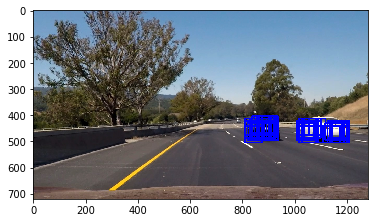

In [12]:
test_image = test_images[5]
y_start_stop = [350, 680]
window_list = slide_window(test_image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(64, 64), xy_overlap=(0.85, 0.85))
on_windows = search_windows(test_image, windows = window_list, svc = svc, X_scaler = X_scaler, param = param)
imcp = draw_boxes(np.copy(test_image), on_windows)
plt.imshow(imcp)
plt.show()

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
n_frames = 10
heatmaps = deque(maxlen = n_frames) 
def process_image_slow(img):
    on_windows = search_windows(img, windows = window_list, svc = svc, X_scaler = X_scaler, param = param)   
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, on_windows)
    heatmaps.append(heatmap_img)
    combined = sum(heatmaps)
    heatmap_img = apply_threshold(combined, 5)
    #heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
test_idx = 2;
test_img = test_images[test_idx]
t =time.time()
draw_img = process_image_slow(test_img)
t2=time.time()
print(round(t2-t, 2), 'Seconds to process image...')

f, axarr = plt.subplots(1, 2, figsize = (128, 128))
axarr[0].imshow(test_img)
axarr[0].set_title('Original test image',fontweight="bold", size=60)
axarr[1].imshow(draw_img)
axarr[1].set_title('Identified vehicles',fontweight="bold", size=60)
plt.show()

In [ ]:
# showing the heatmap
on_windows = search_windows(test_img, windows = window_list, svc = svc, X_scaler = X_scaler, param = param)   
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, on_windows)
heatmap_img = apply_threshold(heatmap_img, 1)
heatmap = np.clip(heatmap_img, 0, 255)
plt.imshow(heatmap)
plt.show()

In [ ]:
from moviepy.editor import VideoFileClip
input_video_fname = 'test_video.mp4'
output_video_fname = 'out_test_video.mp4'
input_clip = VideoFileClip(input_video_fname)    
out_clip = input_clip.fl_image(process_image_slow)
out_clip.write_videofile(output_video_fname, audio=False)   

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def convert_color(img, conv='RGB2HLS'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    

def find_cars(img, ystart, ystop, scale, svc, X_scaler, param, show_img = False):
    orient = param.orient
    pix_per_cell = param.pix_per_cell
    cell_per_block = param.cell_per_block
    spatial_size = param.spatial_size
    hist_bins = param.hist_bins    
    
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                windows.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    
    if show_img:
        return windows, draw_img
    else:
        return windows
    

In [15]:
def process_image_fast(img):
    # parameter definitions
    threshold = 1
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # the pipeline 
    on_windows = []
    ystart = 400
    ystop = 500
    scale = 1
    on_windows_small = find_cars(img, ystart, ystop, scale, svc, X_scaler, param, show_img = False)
    on_windows.extend(on_windows_small)
    ystart = 400
    ystop = 680
    scale = 1.5
    on_windows_mid = find_cars(img, ystart, ystop, scale, svc, X_scaler, param, show_img = False)
    on_windows.extend(on_windows_mid)
    ystart = 500
    ystop = 680
    scale = 2
    on_windows_large = find_cars(img, ystart, ystop, scale, svc, X_scaler, param, show_img = False)
    on_windows.extend(on_windows_large)
    
    heat = add_heat(heat, on_windows)
    # Apply threshold to help remove false positives
    #heatmaps.append(heat)
    #combined = sum(heatmaps)
    heat = apply_threshold(heat, threshold)
    labels = label(heat)    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [ ]:
test_idx = 2;
test_img = test_images[test_idx]
t =time.time()
draw_img = process_image_fast(test_img)
t2=time.time()
print(round(t2-t, 2), 'Seconds to process image...')

f, axarr = plt.subplots(1, 2, figsize = (128, 128))
axarr[0].imshow(test_img)
axarr[0].set_title('Original test image',fontweight="bold", size=60)
axarr[1].imshow(draw_img)
axarr[1].set_title('Identified vehicles',fontweight="bold", size=60)
plt.show()

In [17]:
from moviepy.editor import VideoFileClip
input_video_fname = 'project_video.mp4'
output_video_fname = 'out_project_video.mp4'
input_clip = VideoFileClip(input_video_fname)    
out_clip = input_clip.fl_image(process_image_fast)
out_clip.write_videofile(output_video_fname, audio=False)   


[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|██████████████████████████████████████████████████████████████████████████▉| 1260/1261 [12:19<00:00,  1.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

